In [1]:

import sys
sys.path.append('dataloader')

from pair_dataset import PairDataset

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tranformation_utils import *


DATASET_PATH = "dataloader/data/full/SAMPLE_001"

os.path.exists(DATASET_PATH)

rtstruct_path1 = (
    DATASET_PATH + "/RS.1.2.246.352.221.53086809173815688567595866456863246500.dcm"
)
rtstruct_path2 = (
    DATASET_PATH + "/RS.1.2.246.352.221.46272062591570509005209218152822185346.dcm"
)


# DATASET_PATH = "dataloader/data/full/SAMPLE_002"

# rtstruct_path1 = (
#         DATASET_PATH +"/" + "/RS.1.2.246.352.221.4648407614349067913684963238765492101.dcm"
#     )
# rtstruct_path2 = (
#         DATASET_PATH  +"/" +  "RS.1.2.246.352.221.5699426928750258714918816447807823764.dcm"
#     )

# dataset = PairDataset(rtstruct_path1, rtstruct_path2)

size = 128
size = 1024
dataset = PairDataset(rtstruct_path2, rtstruct_path1, (size, size))

In [2]:
#  do pair dataset nahradit           from dataloader.rs_dataset import RSDataset
y_cutoff = 90 * int(size / 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


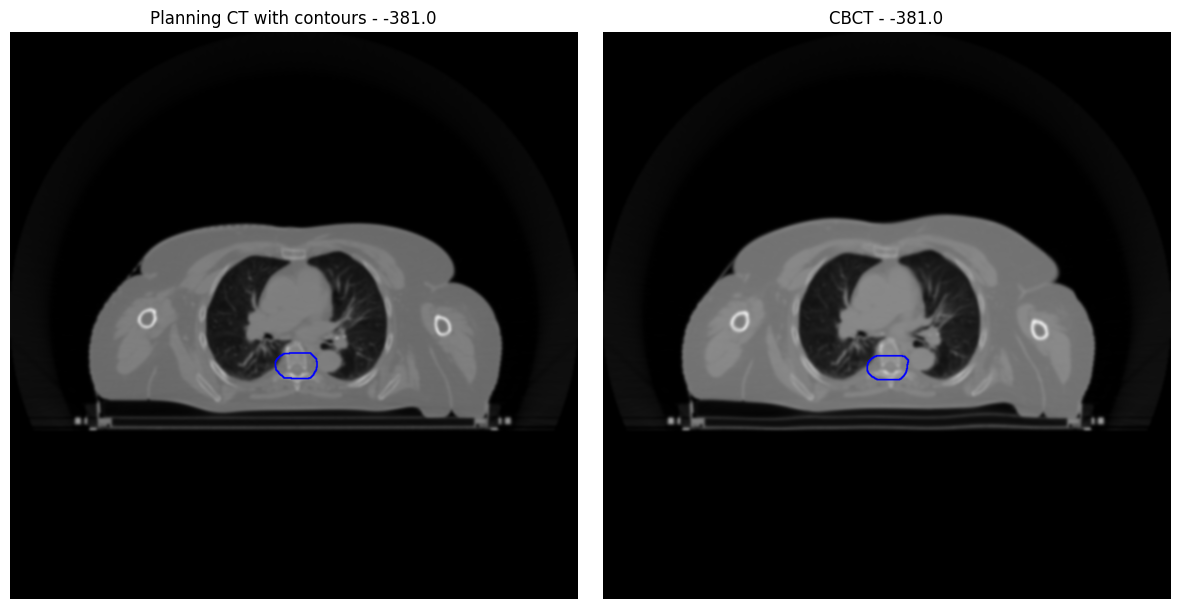

(1024, 1024)
(1024, 1024)
(1024, 1024)


AttributeError: 'builtin_function_or_method' object has no attribute 'cpu'

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tranformation_utils import *

dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
ct1 = None
ct2 = None
for i, batch in enumerate(dataloader):
    # if i != 2:
    #     continue
    # print(f"1 Batch shape: {batch['item1']['ct'].shape}")
    # #display(batch["item2"]["ct"])
    # print(f"2 Batch shape: {batch['item1']['ct'].shape}")
    
    ct_batch1 = batch["item1"]["ct"]
    ct_batch2 = batch["item2"]["ct"]
    z_positions = batch["item1"]["z_position"]
    #print(batch["item1"])
    batch_masks = batch["item1"]["masks"]
    batch_mask2 = batch["item2"]["masks"]
    
    

    #y_cutoff = 500 * int(size / 128)

    # print(f"CT batch shape: {ct_batch1.shape}")
    for i in range(ct_batch1.shape[0]):
        # Convert tensors to NumPy arrays
        ct_img1 = ct_batch1[i, 0].detach().cpu().numpy()  # [H, W]
        ct_img2 = ct_batch2[i, 0].detach().cpu().numpy()
        z_pos = z_positions[i].item() if hasattr(z_positions[i], "item") else z_positions[i]
        masks = batch_masks[i].detach().cpu().numpy()
        masks2 = batch_mask2[i].detach().cpu().numpy()

        ct_img1[y_cutoff:, :] = 0
        ct_img2[y_cutoff:, :] = 0

        
        # Convert to SimpleITK images
        planning_ct_img = sitk.GetImageFromArray(ct_img1)
        cbct_img = sitk.GetImageFromArray(ct_img2)

        # Apply smoothing
        smoothed_planning = sitk.SmoothingRecursiveGaussian(planning_ct_img, sigma=2.0)
        smoothed_cbct = sitk.SmoothingRecursiveGaussian(cbct_img, sigma=2.0)
        
        planning_with_contours = draw_contours(sitk.GetArrayFromImage(smoothed_planning), masks)
        cbct_with_contours = draw_contours(sitk.GetArrayFromImage(smoothed_cbct), masks2)
        plot_images_np(planning_with_contours, cbct_with_contours, title=f"Planning CT with contours - {z_pos}", title2=f"CBCT - {z_pos}")
        
        # Convert to SimpleITK image
        # Perform rigid registration
        global_transform = perform_rigid_registration_v2(smoothed_cbct, smoothed_planning)
        # Align the planning CT to the CBCT using the global transform
        moved_planning_ct = sitk.Resample(
            smoothed_planning,
            smoothed_cbct,
            global_transform,
            sitk.sitkLinear,
            0,
            smoothed_planning.GetPixelID()
        )
       
        
        # break
        fixed_image = smoothed_cbct   # e.g., CBCT (fixed)
        moving_image = moved_planning_ct   # e.g., Planning CT (moving)

        # Perform deformable registration.
        final_bspline_transform = perform_bspline_registration(fixed_image, moving_image, grid_physical_spacing=[50.0, 50.0, 50.0], number_of_iterations=50)

        # Apply the BSpline transform to get the deformed (fused) image.
        deformed_planned_ct = resample_with_transform(moving_image, fixed_image, final_bspline_transform)
        transformed_masks = transform_masks(masks, fixed_image, global_transform, final_bspline_transform)
        deformed_with_contours = draw_contours(sitk.GetArrayFromImage(deformed_planned_ct), transformed_masks)
        
        mask_tranform = perform_rigid_registration_v2(sitk.GetImageFromArray(masks2[2]), sitk.GetImageFromArray(transformed_masks[2]) )
        translation_vector = mask_tranform.GetTranslation()
        # print(f"Translation vector: {translation_vector}"
        pixel_to_mm = batch["item1"]["pixel_size_mm"].detach().cpu().numpy()[0]*1/4
        translaction_vector = (translation_vector[0]*pixel_to_mm, translation_vector[1]*pixel_to_mm)
        print(f"Translation vector: {translaction_vector} mm")
        
        fixed_image_np = sitk.GetArrayFromImage(fixed_image)
        # deformed_with_contours[y_cutoff:, :] = (0, 0, 0)
        # fixed_image_np[y_cutoff:, :] = 0
        
        
        plot_images_np(deformed_with_contours, cbct_with_contours, title=f"Deformed Planning CT with contours - {z_pos}", title2=f"CBCT - {z_pos}")
        break

        # Convert registered images back to NumPy
        # ct_img1_np = sitk.GetArrayFromImage(smoothed_planning)
        # ct_img2_np = sitk.GetArrayFromImage(moving_image_global_aligned)
        # ct_img1_bin = np.where(ct_img1_np > 0.2, 1, 0)
        # ct_img2_bin = np.where(ct_img2_np > 0.2, 1, 0)
        # plt.imshow(ct_img1_bin, cmap="gray")
        # plt.imshow(ct_img2_bin, cmap="gray")
        # plt.show()
        
        
        continue

        # Apply cutoff
        ct_img1_np[y_cutoff:, :] = 0
        ct_img2_np[y_cutoff:, :] = 0
        
        
        

        # Thresholding
        ct_img1_bin = np.where(ct_img1_np > 0.2, 1, 0)
        ct_img2_bin = np.where(ct_img2_np > 0.2, 1, 0)

        # Difference mask
        diff_mask = (ct_img1_bin != ct_img2_bin).astype(np.uint8)

        # Red overlay for visualization
        overlay = np.stack(
            [diff_mask * 255, np.zeros_like(diff_mask), np.zeros_like(diff_mask)],
            axis=-1,
        )

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(ct_img1_bin, cmap="gray")
        axs[0].set_title(f"Item1 - Z: {z_pos} | Y Cutoff: {y_cutoff}")
        axs[0].axis("off")

        axs[1].imshow(ct_img2_bin, cmap="gray")
        axs[1].set_title(f"Item2 - Z: {z_pos} | Y Cutoff: {y_cutoff}")
        axs[1].axis("off")

        # Difference ratio
        num_diff_pixels = np.sum(diff_mask)
        num_white_pixels_img1 = np.sum(ct_img1_bin == 1)
        num_white_pixels_img2 = np.sum(ct_img2_bin == 1)

        if (num_white_pixels_img1 + num_white_pixels_img2) > 0:
            diff_ratio = num_diff_pixels / (
                (num_white_pixels_img1 + num_white_pixels_img2) / 2
            )
        else:
            diff_ratio = 0.0

        axs[2].imshow(ct_img1_bin, cmap="gray")
        axs[2].imshow(overlay, alpha=0.6)
        axs[2].set_title(f"Diffs (red) | Ratio: {diff_ratio:.4f}")
        axs[2].axis("off")

        print(
            f"Item {i} - Z: {z_pos} | Diff Pixels: {num_diff_pixels}, "
            f"White Pixels (img2): {num_white_pixels_img2}, Ratio: {diff_ratio:.4f}"
        )

        plt.tight_layout()
        plt.show()
        break
    


In [8]:
masks2[0].max()

0.0

In [ ]:
import cv2 

def draw_contours(img, masks):
    ct_img_colored = np.stack([img, img, img], axis=-1)
    colors = ['orange', 'red', 'blue']
    colors_rgb = {'orange': [1.0, 0.65, 0], 'red': [1.0, 0, 0], 'blue': [0, 0, 1.0]}
    
    for i in range(3):
        mask_layer = masks[i]
        # Convert to uint8 for findContours
        mask_uint8 = (mask_layer * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw contours in the corresponding color
        color = colors_rgb[colors[i]]
        for contour in contours:
            cv2.drawContours(ct_img_colored, [contour], -1, color, 2)
    return ct_img_colored
    

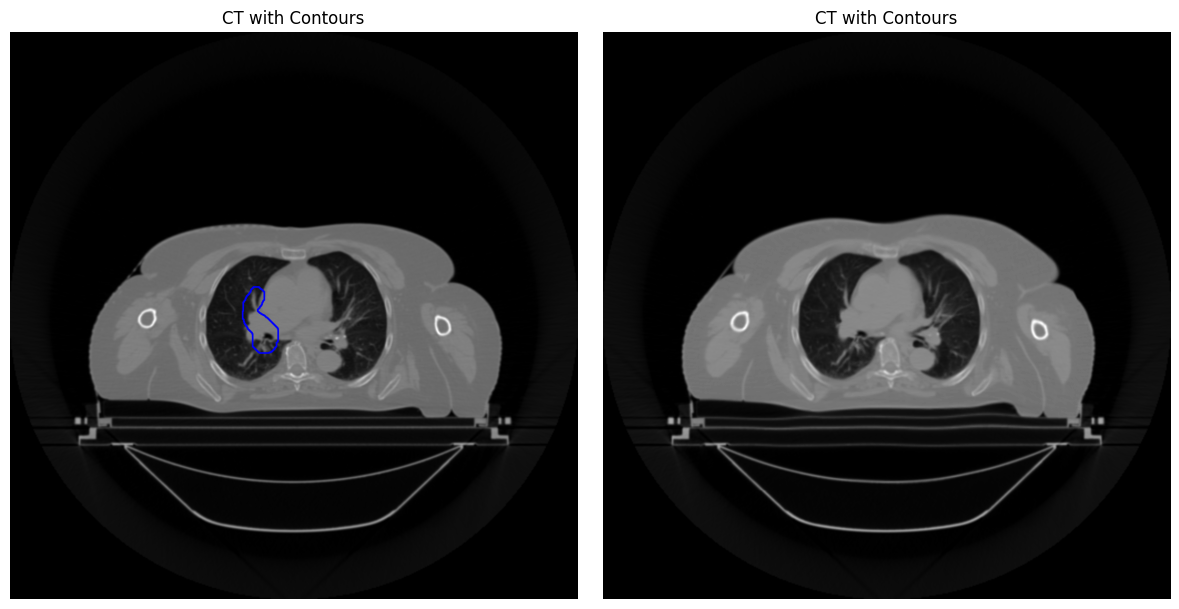

In [ ]:
import cv2

batch_masks = batch["item1"]["masks"]
batch_masks = batch_masks.detach().cpu().numpy() 
masks = batch_masks[0]  # Assuming batch size is 1

ct_img_colored = draw_contours(ct_img1, masks)

plot_images_np(ct_img_colored, ct_img2, title='CT with Contours', title2='CT with Contours')


In [ ]:
def transform_masks(masks, fixed_image, global_transform, final_bspline_transform ):
    transformed_masks = []
    for mask in masks:
        print(mask.shape)
        # Convert to SimpleITK image
        mask_sitk = sitk.GetImageFromArray(mask)
        moved_mask = sitk.Resample(
            mask_sitk,
            fixed_image,
            global_transform,
            sitk.sitkLinear,
            0,
            mask_sitk.GetPixelID()
        )
        # Resample the mask using the transform
        deformed_mask = resample_with_transform(moved_mask, fixed_image, final_bspline_transform)

        transformed_masks.append(sitk.GetArrayFromImage(deformed_mask))
    return np.array(transformed_masks)

transformed_masks = transform_masks(masks, fixed_image, global_transform, final_bspline_transform)
# ct_transformed_mask = draw_contours(fused_deformed_image, masks)
# plot_images_np(ct_transformed_mask, ct_img_colored, title='CT with Contours', title2='CT with Contours')


(1024, 1024)
(1024, 1024)
(1024, 1024)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


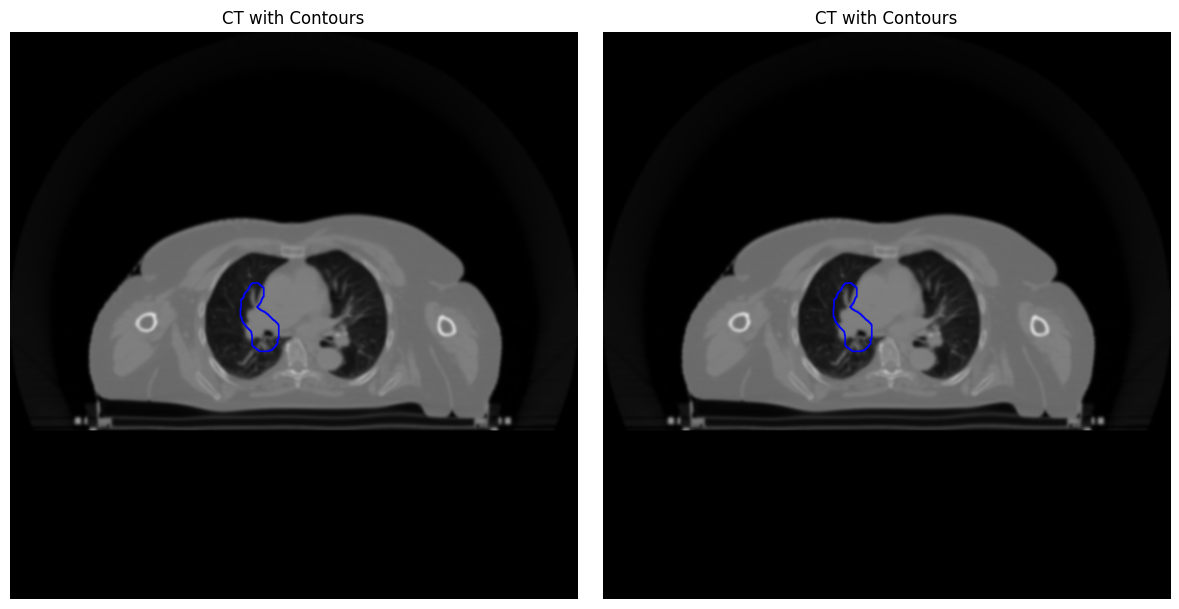

In [ ]:



# ct_transformed_mask = draw_contours(sitk.GetArrayFromImage(fused_deformed_image), transformed_masks)
plot_images_np(deformed_with_contours, deformed_with_contours, title='CT with Contours', title2='CT with Contours')